# State reducers
- When updating same shared states in parallel, if we don't use reducers, it will throw an error as we can't update the same state simulataneously
- We need to use Annotated + reducers to do this
- e.g for a case where we add 1 to the previous node from both of it's child node, reducer would be add and we can use Annotated[list[int], add] to handle this

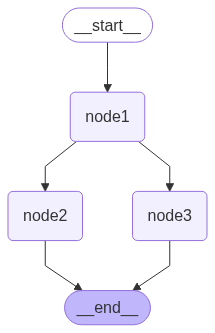

In [8]:
from operator import add
from typing import Annotated
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# defining state
class State(BaseModel):
    foo: Annotated[list[int], add] = Field(..., description="A list of integers")
    
# build graph
def node1(state:State):
    print(f"Node 1: {state.model_dump()['foo'][-1]}")
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node2(state:State):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node3(state:State):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

# build graph

builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node1", "node3")
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

We can see 2 and 3 update the value from node 1 in parallel

In [11]:
graph.invoke({"foo":None})

TypeError: can only concatenate list (not "NoneType") to list

# Using custom reducers
- Can use our own reducer logic to combine inputs

In [12]:
def custom_reducer(left: list| None, right: list| None) -> list:
    """
    Safely combine two lists

    Args:
        left (list | None): First list to combine or None
        right (list | None): Second list to combine or None

    Returns:
        list: A new list containing all elements from both input lists
        If an input is None, it's treated as emoty list
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

# class to use custom reducer
class CustomReducerState(BaseModel):
    foo: Annotated[list[int], custom_reducer] = Field(..., description="A list of integers")

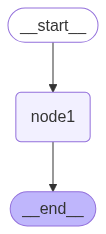

In [25]:
# buid a graph with custom reducer state:
# build graph
def node1(state:CustomReducerState):
    #print(f"Node 1: {state.model_dump()['foo'][-1]}")
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node2(state:CustomReducerState):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

def node3(state:CustomReducerState):
    return {"foo":[state.model_dump()['foo'][-1] + 1]}

# build graph

builder = StateGraph(CustomReducerState)
builder.add_node("node1", node1)


builder.add_edge(START, "node1")
builder.add_edge("node1", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
graph.invoke({"foo":None})

IndexError: list index out of range

# Messages
- Can rewrite messages when we supply ids along with messages. We can replace message content for a particular message id
- We can overrite or remove messages using these ids

In [30]:
from langchain_core.messages import AIMessage,HumanMessage
from langgraph.graph.message import add_messages


initial_messages = [
    AIMessage(content = "Hello! How can I assist you today?", id = "1"),
    HumanMessage(content= "I am looking for a restaurant in the city", id = "2"),
]

new_message = HumanMessage(content= "I am looking for a car in the city", id = "2")
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content='I am looking for a car in the city', additional_kwargs={}, response_metadata={}, id='2')]

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage

messages = [AIMessage(content = "Hello! How can I assist you today?",name="Bot", id = "1"),
            HumanMessage(content = "I am looking for a restaurant in the city", name="User", id = "2"),
            AIMessage(content = "So you said you are looking for a restaurant in the city?", name="Bot", id = "3"),
            HumanMessage(content = "Yes, I am looking for a restaurant in the city", name="User", id = "4")]

# deleting the 2 most recent messages
deleted_messages = [RemoveMessage(id = m.id) for m in messages[-2:]]